In [1]:
from spectral import *
import numpy as np
img = open_image('Siwana.hdr')  # Make sure this path is correct
data = img.load()
print(f"Image shape: {data.shape}")  # (rows, cols, bands)

Image shape: (759, 759, 244)


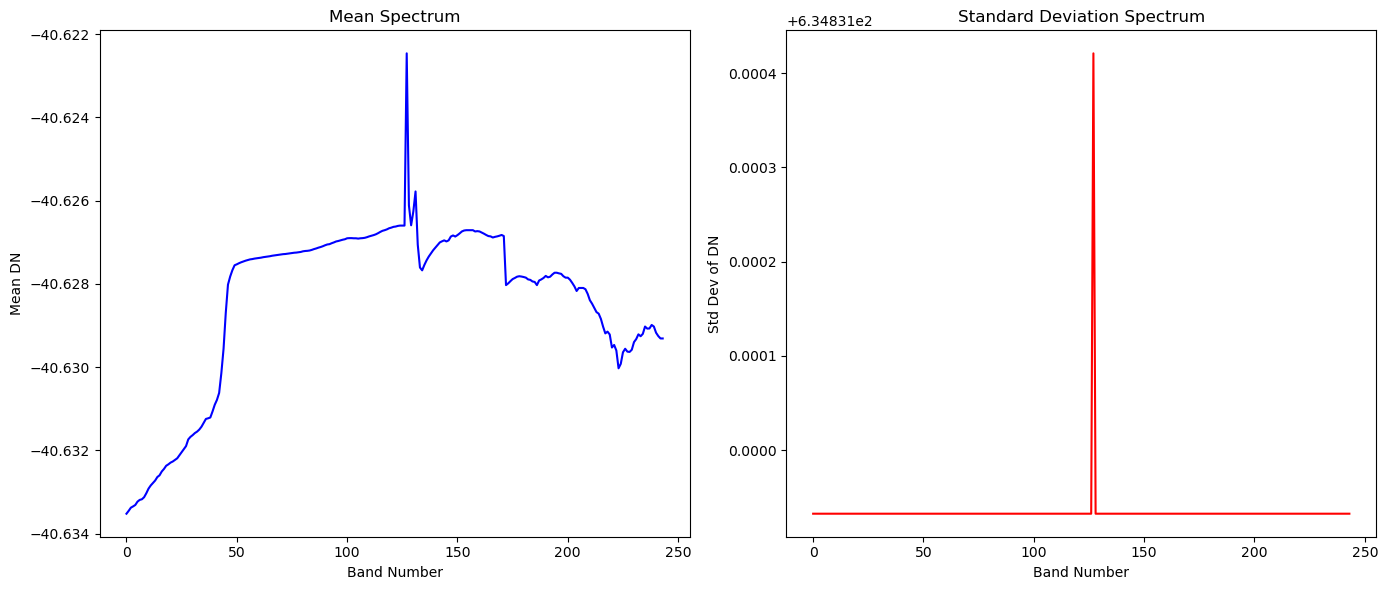

In [2]:
import matplotlib.pyplot as plt
rows, cols, bands = data.shape
reshaped = data.reshape((rows * cols, bands))
nonzero_pixels = reshaped[~np.all(reshaped == 0, axis=1)]
mean_spectrum = np.mean(nonzero_pixels, axis=0)
std_spectrum = np.std(nonzero_pixels, axis=0)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(mean_spectrum, color='blue')
plt.title('Mean Spectrum')
plt.xlabel('Band Number')
plt.ylabel('Mean DN')
plt.subplot(1,2,2)
plt.plot(std_spectrum, color='red')
plt.title('Standard Deviation Spectrum')
plt.xlabel('Band Number')
plt.ylabel('Std Dev of DN')
plt.tight_layout()
plt.show()

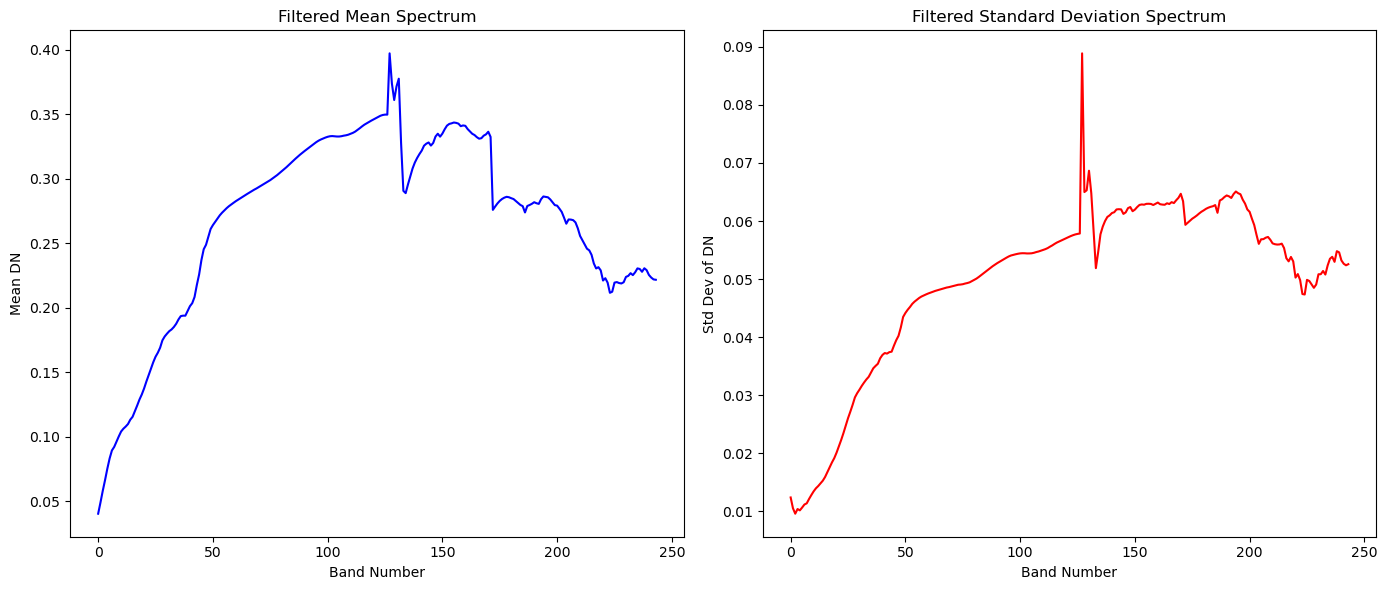

In [3]:
threshold = -100  # adjust if needed (for DN scale)
valid_pixels = reshaped[np.max(reshaped, axis=1) > threshold]
mean_spectrum = np.mean(valid_pixels, axis=0)
std_spectrum = np.std(valid_pixels, axis=0)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(mean_spectrum, color='blue')
plt.title('Filtered Mean Spectrum')
plt.xlabel('Band Number')
plt.ylabel('Mean DN')
plt.subplot(1,2,2)
plt.plot(std_spectrum, color='red')
plt.title('Filtered Standard Deviation Spectrum')
plt.xlabel('Band Number')
plt.ylabel('Std Dev of DN')
plt.tight_layout()
plt.show()

In [4]:
bad_bands = list(range(0, 6)) + list(range(125, 136)) + list(range(145, 156)) + list(range(220, 244))
all_bands = list(range(244))
good_bands = [b for b in all_bands if b not in bad_bands]
cleaned_data = data[:, :, good_bands]
print(f"Final cleaned image shape: {cleaned_data.shape}")

Final cleaned image shape: (759, 759, 192)


In [5]:
import numpy as np
import pandas as pd
def load_roi_spectra(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    data_lines = [l for l in lines if not l.startswith(';') and len(l.strip()) > 0]
    spectra = []
    for line in data_lines:
        parts = line.strip().split()
        bands = [float(x) for x in parts[5:]]  # Skip ID, X, Y, Lat, Lon
        spectra.append(bands)
    return np.array(spectra)
rhyolite = load_roi_spectra('RHYOLITE.txt')
granite = load_roi_spectra('granite.txt')
salt_silt = load_roi_spectra('SALT.txt')
print("Rhyolite ROI:", rhyolite.shape)
print("Granite ROI:", granite.shape)
print("Salt & Silt ROI:", salt_silt.shape)

Rhyolite ROI: (2618, 244)
Granite ROI: (2974, 244)
Salt & Silt ROI: (2422, 244)


In [6]:
bad_bands = list(range(0, 6)) + list(range(125, 136)) + list(range(145, 156)) + list(range(220, 244))
good_bands = [i for i in range(244) if i not in bad_bands]
rhyolite_clean = rhyolite[:, good_bands]
granite_clean = granite[:, good_bands]
salt_silt_clean = salt_silt[:, good_bands]
mean_rhyolite = np.mean(rhyolite_clean, axis=0)
mean_granite = np.mean(granite_clean, axis=0)
mean_salt_silt = np.mean(salt_silt_clean, axis=0)

In [7]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
def continuum_removal(spectrum):
    x = np.arange(len(spectrum))
    peaks, _ = find_peaks(spectrum)
    if len(peaks) < 2:
        return spectrum  # Skip if not enough peaks
    peak_x = np.concatenate(([0], peaks, [len(spectrum)-1]))
    peak_y = spectrum[peak_x]
    f = interp1d(peak_x, peak_y, kind='linear', fill_value="extrapolate")
    continuum = f(x)
    continuum = np.where(continuum == 0, 1e-6, continuum)
    return spectrum / continuum
cr_rhyolite = continuum_removal(mean_rhyolite)
cr_granite = continuum_removal(mean_granite)
cr_salt_silt = continuum_removal(mean_salt_silt)

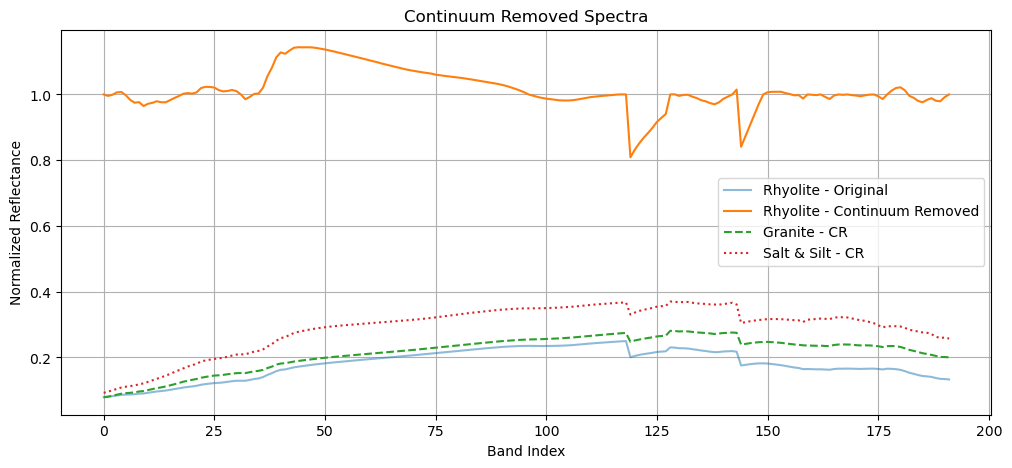

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(mean_rhyolite, label='Rhyolite - Original', alpha=0.5)
plt.plot(cr_rhyolite, label='Rhyolite - Continuum Removed')
plt.plot(mean_granite, label='Granite - CR', linestyle='--')
plt.plot(mean_salt_silt, label='Salt & Silt - CR', linestyle=':')
plt.title('Continuum Removed Spectra')
plt.xlabel('Band Index')
plt.ylabel('Normalized Reflectance')
plt.legend()
plt.grid()
plt.show()

In [10]:
from numpy import newaxis
rows, cols, bands = cleaned_data.shape
flat_img = cleaned_data.reshape((rows * cols, bands))
def normalize(v):
    return v / (np.linalg.norm(v, axis=-1, keepdims=True) + 1e-6)
flat_img_norm = normalize(flat_img)
ref_rhyolite = normalize(cr_rhyolite)
ref_granite = normalize(cr_granite)
ref_salt_silt = normalize(cr_salt_silt)
def spectral_angle(img_pixels, reference):
    dot = np.dot(img_pixels, reference)
    return np.arccos(np.clip(dot, -1, 1))  # angle in radians
angle_rhyolite = spectral_angle(flat_img_norm, ref_rhyolite)
angle_granite = spectral_angle(flat_img_norm, ref_granite)
angle_salt = spectral_angle(flat_img_norm, ref_salt_silt)
all_angles = np.vstack([angle_rhyolite, angle_granite, angle_salt])  # shape: (3, pixels)
classified = np.argmin(all_angles, axis=0)  # class index per pixel
classified_img = classified.reshape((rows, cols))
print("SAM classification complete. Unique classes:", np.unique(classified_img))

SAM classification complete. Unique classes: [0 1 2]


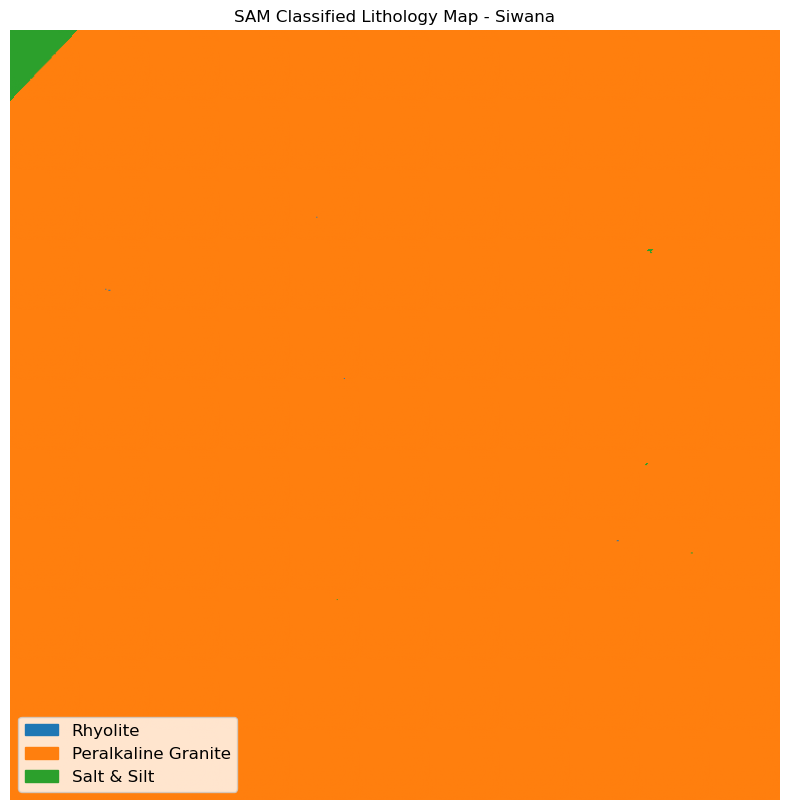

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
colors = ['orange', 'blue', 'lightgreen']  # 0, 1, 2
class_names = ['Rhyolite', 'Peralkaline Granite', 'Salt & Silt']
rgb_img = np.zeros((rows, cols, 3))
for i, color in enumerate(colors):
    mask = (classified_img == i)
    rgb = plt.get_cmap('tab10')(i)[:3]  # Extract RGB from colormap
    rgb_img[mask] = rgb
plt.figure(figsize=(10,10))
plt.imshow(rgb_img)
plt.title("SAM Classified Lithology Map - Siwana")
plt.axis('off')
legend_handles = [mpatches.Patch(color=plt.get_cmap('tab10')(i)[:3], label=name)
                  for i, name in enumerate(class_names)]
plt.legend(handles=legend_handles, loc='lower left', fontsize='large')
plt.show()

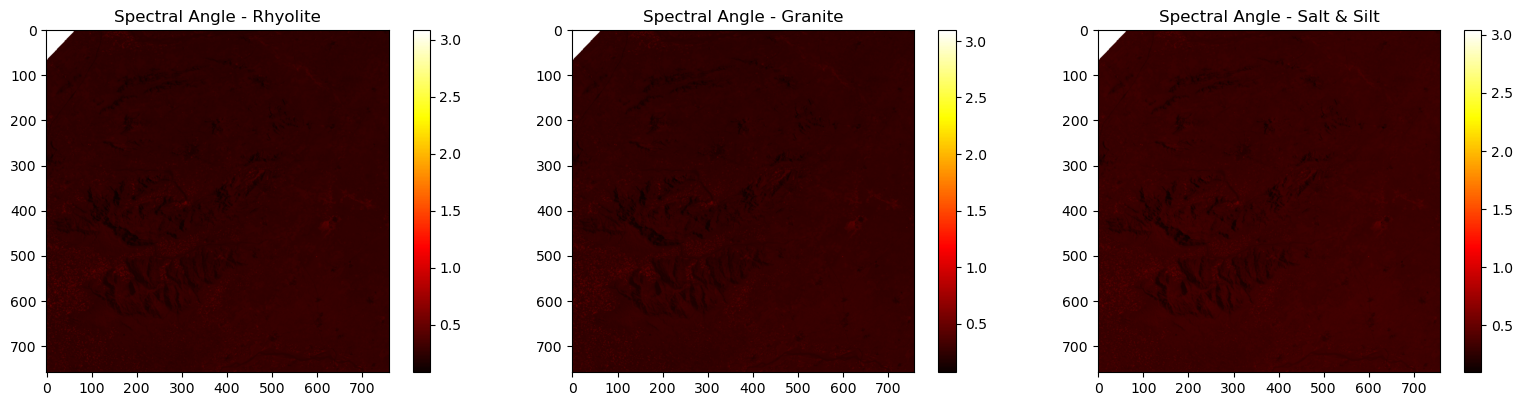

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(angle_rhyolite.reshape(rows, cols), cmap='hot')
plt.title("Spectral Angle - Rhyolite")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(angle_granite.reshape(rows, cols), cmap='hot')
plt.title("Spectral Angle - Granite")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(angle_salt.reshape(rows, cols), cmap='hot')
plt.title("Spectral Angle - Salt & Silt")
plt.colorbar()
plt.tight_layout()
plt.show()

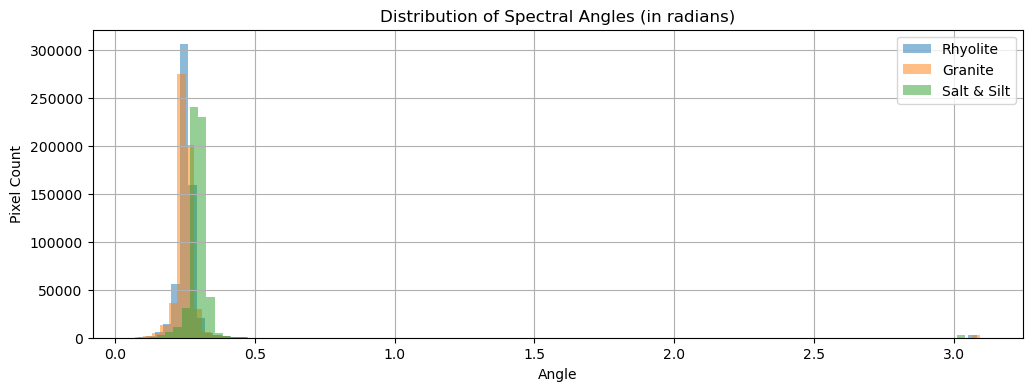

In [13]:
plt.figure(figsize=(12,4))
plt.hist(angle_rhyolite, bins=100, alpha=0.5, label='Rhyolite')
plt.hist(angle_granite, bins=100, alpha=0.5, label='Granite')
plt.hist(angle_salt, bins=100, alpha=0.5, label='Salt & Silt')
plt.title("Distribution of Spectral Angles (in radians)")
plt.xlabel("Angle")
plt.ylabel("Pixel Count")
plt.legend()
plt.grid()
plt.show()

In [16]:
thresholds = [0.25, 0.25, 0.25]
mask_rhyolite = (angle_rhyolite < thresholds[0])
mask_granite = (angle_granite < thresholds[1])
mask_salt = (angle_salt < thresholds[2])
classified_rule = np.full(flat_img.shape[0], fill_value=-1)  # -1 = unclassified
for i in range(flat_img.shape[0]):
    options = []
    if mask_rhyolite[i]: options.append((angle_rhyolite[i], 0))
    if mask_granite[i]: options.append((angle_granite[i], 1))
    if mask_salt[i]: options.append((angle_salt[i], 2))
    if options:
        best = min(options, key=lambda x: x[0])
        classified_rule[i] = best[1]
classified_rule_img = classified_rule.reshape((rows, cols))

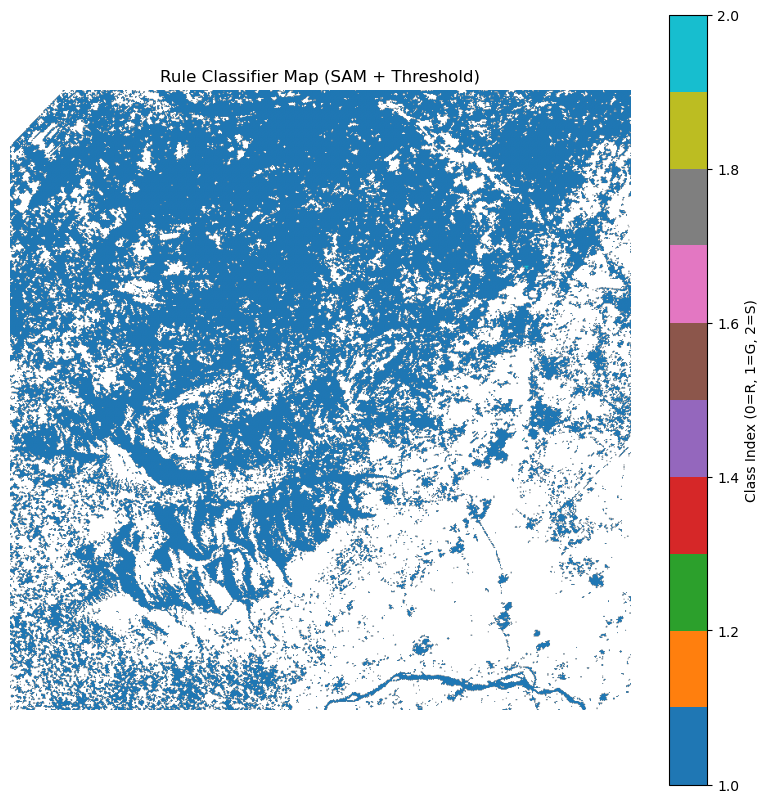

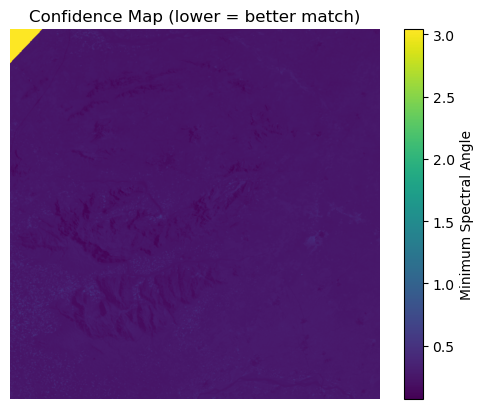

In [17]:
plt.figure(figsize=(10,10))
masked = np.ma.masked_where(classified_rule_img == -1, classified_rule_img)
plt.imshow(masked, cmap='tab10')
plt.title("Rule Classifier Map (SAM + Threshold)")
plt.axis('off')
plt.colorbar(label="Class Index (0=R, 1=G, 2=S)")
plt.show()
min_angle = np.min(np.vstack([angle_rhyolite, angle_granite, angle_salt]), axis=0)
plt.imshow(min_angle.reshape(rows, cols), cmap='viridis')
plt.colorbar(label='Minimum Spectral Angle')
plt.title("Confidence Map (lower = better match)")
plt.axis('off')
plt.show()

In [18]:
img = open_image('Siwana.hdr') # adjust filename if needed
cube = img.load()
print("Image shape:", cube.shape)
print("Data type:", cube.dtype)

Image shape: (759, 759, 244)
Data type: float32


In [21]:
import numpy as np
def load_roi(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    clean_lines = [l.strip().split() for l in lines if not l.startswith(';') and l.strip()]
    spectra = []
    for l in clean_lines:
        try:
            values = list(map(float, l[5:]))  # Skip ID, X, Y, Lat, Lon
            spectra.append(values)
        except:
            continue  # Skip malformed lines
    return np.array(spectra)
rhyolite = load_roi('RHYOLITE.txt')
granite = load_roi('granite.txt')
salt = load_roi('SALT.txt')
print("Rhyolite shape:", rhyolite.shape)
print("Granite shape:", granite.shape)
print("Salt shape:", salt.shape)

Rhyolite shape: (2618, 244)
Granite shape: (2974, 244)
Salt shape: (2422, 244)


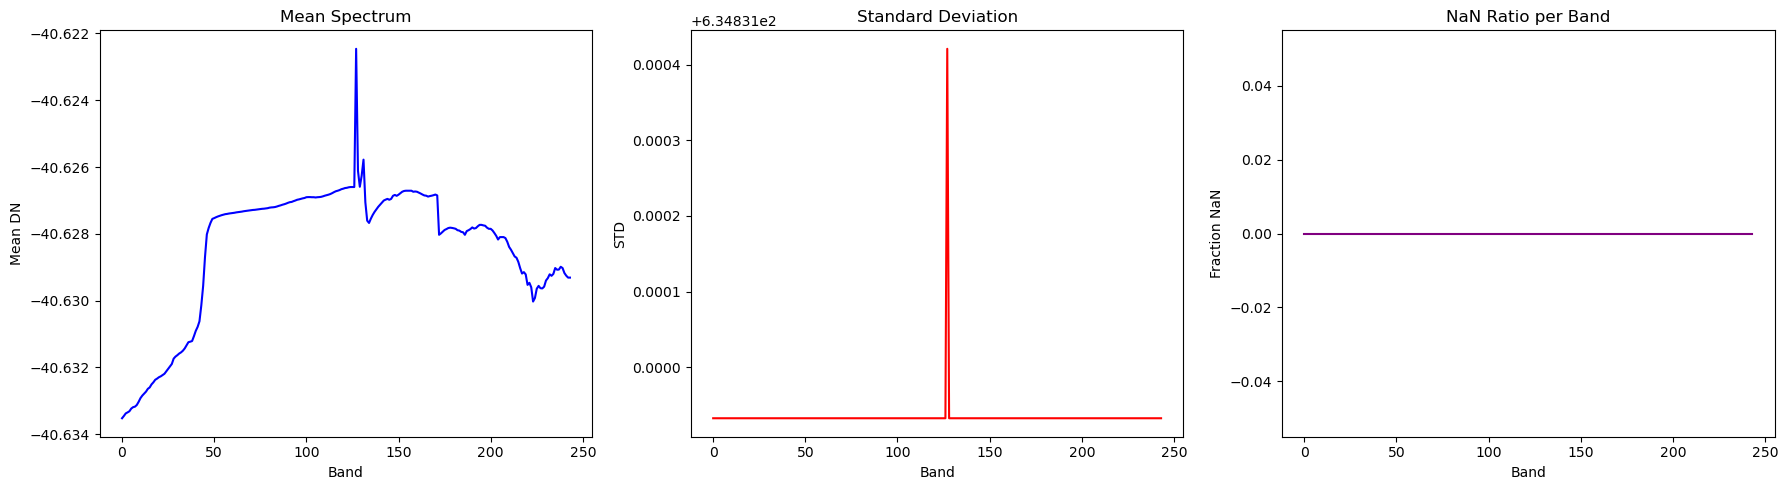

In [22]:
import matplotlib.pyplot as plt
import numpy as np
rows, cols, bands = cube.shape
reshaped = cube.reshape(-1, bands)
valid_mask = ~np.isnan(reshaped).any(axis=1) & (np.max(np.abs(reshaped), axis=1) > 1e-4)
valid_pixels = reshaped[valid_mask]
mean_spectrum = np.nanmean(valid_pixels, axis=0)
std_spectrum = np.nanstd(valid_pixels, axis=0)
nan_ratio = np.mean(np.isnan(reshaped), axis=0)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(mean_spectrum, label='Mean', color='blue')
plt.title("Mean Spectrum")
plt.xlabel("Band")
plt.ylabel("Mean DN")
plt.subplot(1, 3, 2)
plt.plot(std_spectrum, label='STD', color='red')
plt.title("Standard Deviation")
plt.xlabel("Band")
plt.ylabel("STD")
plt.subplot(1, 3, 3)
plt.plot(nan_ratio, label='NaN Ratio', color='purple')
plt.title("NaN Ratio per Band")
plt.xlabel("Band")
plt.ylabel("Fraction NaN")
plt.tight_layout()
plt.show()

In [23]:
good_bands = [b for b in range(244) if b not in list(range(0, 6)) + list(range(115, 131)) + list(range(170, 244))]
cube_clean = cube[:, :, good_bands]
print("Cleaned cube shape:", cube_clean.shape)
rhyolite_clean = rhyolite[:, good_bands]
granite_clean = granite[:, good_bands]
salt_clean = salt[:, good_bands]
print("Cleaned Rhyolite shape:", rhyolite_clean.shape)

Cleaned cube shape: (759, 759, 148)
Cleaned Rhyolite shape: (2618, 148)


In [24]:
bad_bands = list(range(0, 6)) + list(range(115, 131)) + list(range(170, 244))
good_bands = [b for b in range(244) if b not in bad_bands]
cube_clean = cube[:, :, good_bands]
print("Cleaned image shape:", cube_clean.shape)
rhyolite_clean = rhyolite[:, good_bands]
granite_clean = granite[:, good_bands]
salt_clean = salt[:, good_bands]
print("Cleaned Rhyolite shape:", rhyolite_clean.shape)
print("Cleaned Granite shape:", granite_clean.shape)
print("Cleaned Salt & Silt shape:", salt_clean.shape)

Cleaned image shape: (759, 759, 148)
Cleaned Rhyolite shape: (2618, 148)
Cleaned Granite shape: (2974, 148)
Cleaned Salt & Silt shape: (2422, 148)


In [25]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import numpy as np
def continuum_removal(spectrum):
    x = np.arange(len(spectrum))
    peaks, _ = find_peaks(spectrum)
    if len(peaks) < 2:
        return spectrum  # skip if not enough peaks
    peak_x = np.concatenate(([0], peaks, [len(spectrum)-1]))
    peak_y = spectrum[peak_x]
    hull = interp1d(peak_x, peak_y, kind='linear', fill_value="extrapolate")(x)
    hull = np.where(hull == 0, 1e-6, hull)  # avoid divide-by-zero
    return spectrum / hull

In [26]:
mean_rhyolite = np.mean(rhyolite_clean, axis=0)
mean_granite = np.mean(granite_clean, axis=0)
mean_salt = np.mean(salt_clean, axis=0)
cr_rhyolite = continuum_removal(mean_rhyolite)
cr_granite = continuum_removal(mean_granite)
cr_salt = continuum_removal(mean_salt)

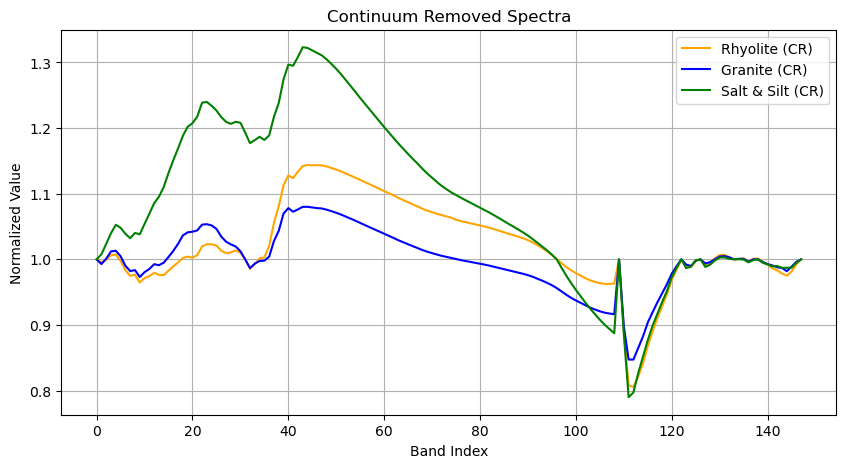

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(cr_rhyolite, label='Rhyolite (CR)', color='orange')
plt.plot(cr_granite, label='Granite (CR)', color='blue')
plt.plot(cr_salt, label='Salt & Silt (CR)', color='green')
plt.title('Continuum Removed Spectra')
plt.xlabel('Band Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from numpy.linalg import norm
import numpy as np
rows, cols, bands = cube_clean.shape
flat_img = cube_clean.reshape((-1, bands))  # shape: (pixels, bands)
def normalize(v):
    return v / (norm(v, axis=-1, keepdims=True) + 1e-8)
flat_img_norm = normalize(flat_img)
ref_rhyolite = normalize(cr_rhyolite)
ref_granite = normalize(cr_granite)
ref_salt = normalize(cr_salt)
def spectral_angle(pixels, reference):
    dot = np.dot(pixels, reference)
    dot = np.clip(dot, -1.0, 1.0)  # for arccos domain
    angle = np.arccos(dot)
    return angle  # radians
angle_rhyolite = spectral_angle(flat_img_norm, ref_rhyolite)
angle_granite = spectral_angle(flat_img_norm, ref_granite)
angle_salt = spectral_angle(flat_img_norm, ref_salt)
angles_all = np.stack([angle_rhyolite, angle_granite, angle_salt], axis=0)  # shape: (3, pixels)
class_indices = np.argmin(angles_all, axis=0)  # class 0,1,2
sam_classified = class_indices.reshape((rows, cols))

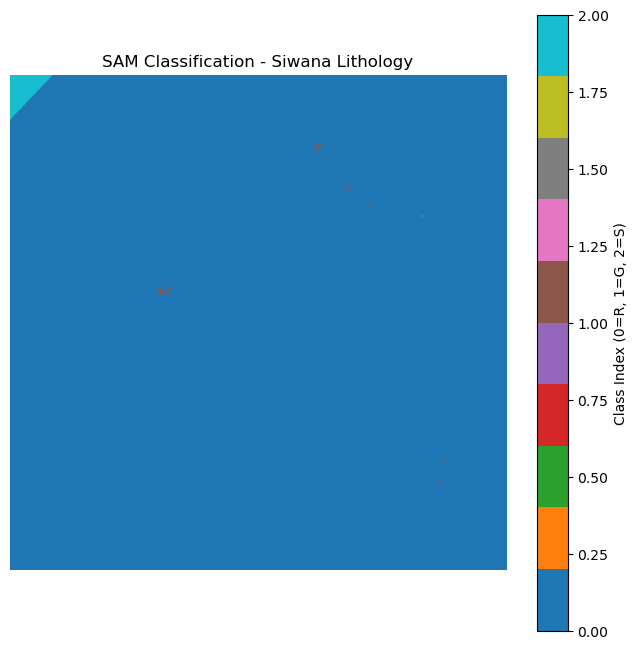

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(sam_classified, cmap='tab10')
plt.title("SAM Classification - Siwana Lithology")
plt.axis('off')
plt.colorbar(label='Class Index (0=R, 1=G, 2=S)')
plt.show()

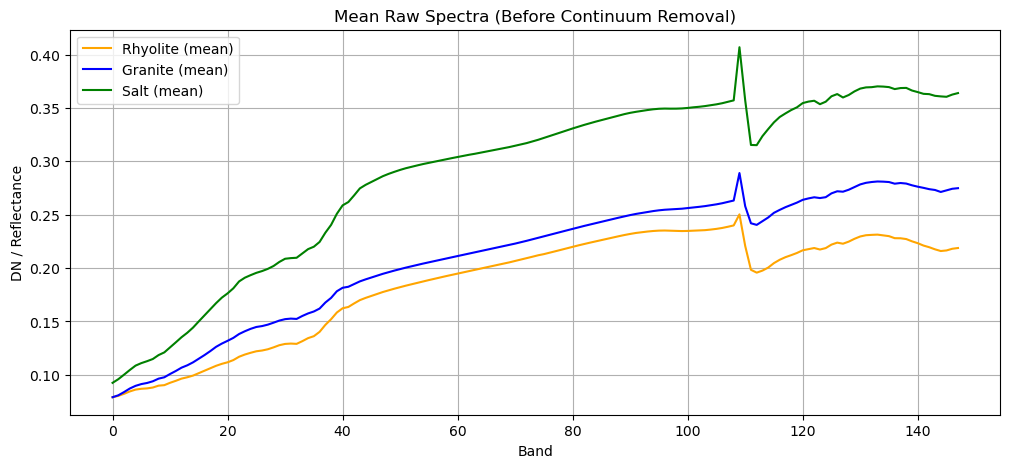

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(np.mean(rhyolite_clean, axis=0), label='Rhyolite (mean)', color='orange')
plt.plot(np.mean(granite_clean, axis=0), label='Granite (mean)', color='blue')
plt.plot(np.mean(salt_clean, axis=0), label='Salt (mean)', color='green')
plt.title("Mean Raw Spectra (Before Continuum Removal)")
plt.xlabel("Band")
plt.ylabel("DN / Reflectance")
plt.grid(True)
plt.legend()
plt.show()

In [33]:
def load_roi_coordinates(file_path):
    coords = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith(';') or line.strip() == '':
                continue
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    x = int(parts[1])
                    y = int(parts[2])
                    coords.append((y, x))  # (row, col)
                except ValueError:
                    continue
    return np.array(coords)
rhyolite_coords = load_roi_coordinates('RHYOLITE.txt')
granite_coords = load_roi_coordinates('granite.txt')
salt_coords = load_roi_coordinates('SALT.txt')

In [34]:
rhyolite_samples = cube[rhyolite_coords[:, 0], rhyolite_coords[:, 1], :]
granite_samples  = cube[granite_coords[:, 0], granite_coords[:, 1], :]
salt_samples     = cube[salt_coords[:, 0], salt_coords[:, 1], :]
X = np.vstack((rhyolite_samples, granite_samples, salt_samples))
y = np.array([0]*len(rhyolite_samples) + [1]*len(granite_samples) + [2]*len(salt_samples))
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5389, 244)
y shape: (5389,)


In [35]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)
print("Training complete.")

Training complete.


In [36]:
rows, cols, bands = cube.shape
flattened_img = cube.reshape((-1, bands))
y_pred = clf.predict(flattened_img)
classified_map = y_pred.reshape(rows, cols)

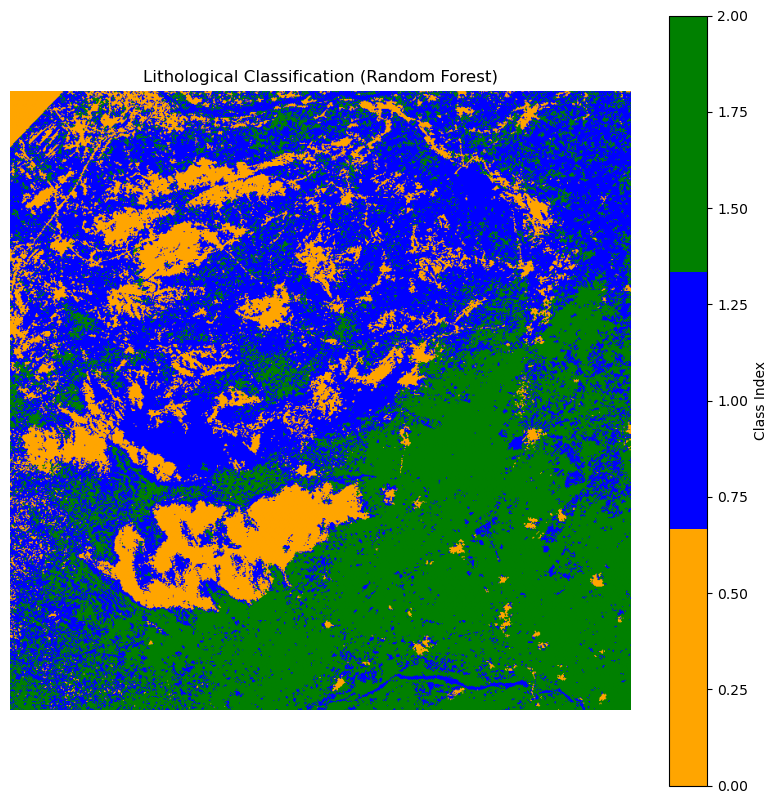

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['orange', 'blue', 'green'])  # 0 = rhyolite, 1 = granite, 2 = salt
plt.figure(figsize=(10, 10))
plt.imshow(classified_map, cmap=cmap)
plt.title('Lithological Classification (Random Forest)')
plt.axis('off')
plt.colorbar(label='Class Index')
plt.show()

In [38]:
X = X[:, good_bands]  # ensures consistency with cleaned cube

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
from sklearn.neural_network import MLPClassifier
ann = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=300, random_state=42)
ann.fit(X_scaled, y)
print("✅ ANN training complete.")

✅ ANN training complete.


In [41]:
rows, cols, bands = cube.shape
flat_img = cube.reshape((-1, bands))[:, good_bands]
flat_img_scaled = scaler.transform(flat_img)
y_pred_ann = ann.predict(flat_img_scaled)
ann_classified = y_pred_ann.reshape(rows, cols)

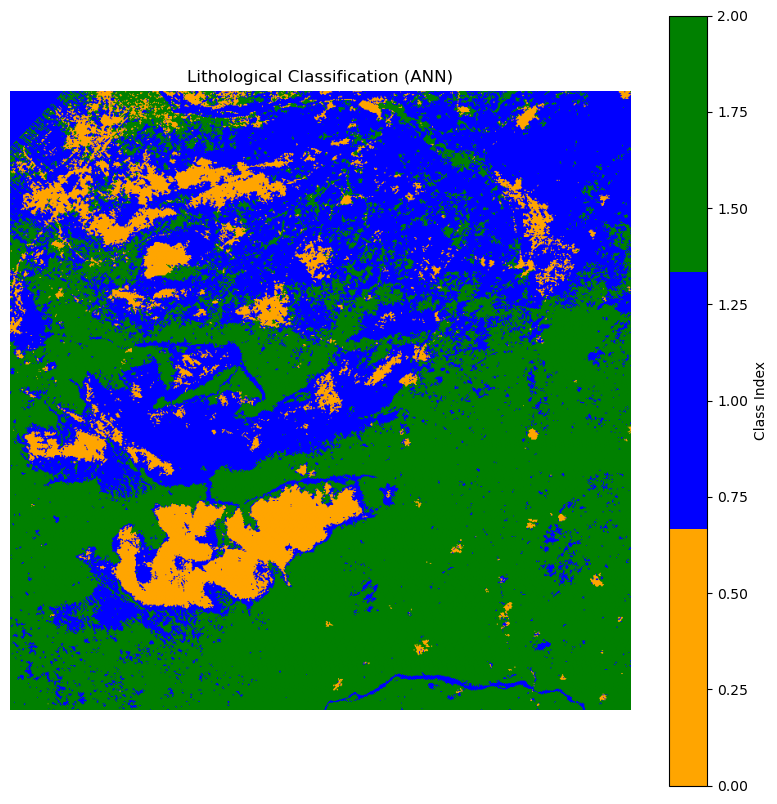

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['orange', 'blue', 'green'])  # 0=rhyolite, 1=granite, 2=salt
plt.figure(figsize=(10, 10))
plt.imshow(ann_classified, cmap=cmap)
plt.title("Lithological Classification (ANN)")
plt.axis('off')
plt.colorbar(label='Class Index')
plt.show()

In [43]:
rhyolite_spectra = X[y == 0]
granite_spectra  = X[y == 1]
salt_spectra     = X[y == 2]
mean_rhyolite = np.mean(rhyolite_spectra, axis=0)
mean_granite  = np.mean(granite_spectra, axis=0)
mean_salt     = np.mean(salt_spectra, axis=0)

In [44]:
from numpy.linalg import norm
def normalize(v):
    return v / (norm(v, axis=-1, keepdims=True) + 1e-8)
mean_rhyolite_norm = normalize(mean_rhyolite)
mean_granite_norm  = normalize(mean_granite)
mean_salt_norm     = normalize(mean_salt)

In [45]:
flat_img = cube.reshape(-1, bands)[:, good_bands]
flat_img_norm = normalize(flat_img)
def spectral_angle(pixels, ref):
    dot = np.dot(pixels, ref)
    dot = np.clip(dot, -1.0, 1.0)
    return np.arccos(dot)
angle_r = spectral_angle(flat_img_norm, mean_rhyolite_norm)
angle_g = spectral_angle(flat_img_norm, mean_granite_norm)
angle_s = spectral_angle(flat_img_norm, mean_salt_norm)
sam_labels = np.argmin(np.stack([angle_r, angle_g, angle_s], axis=0), axis=0)
sam_map = sam_labels.reshape(rows, cols)

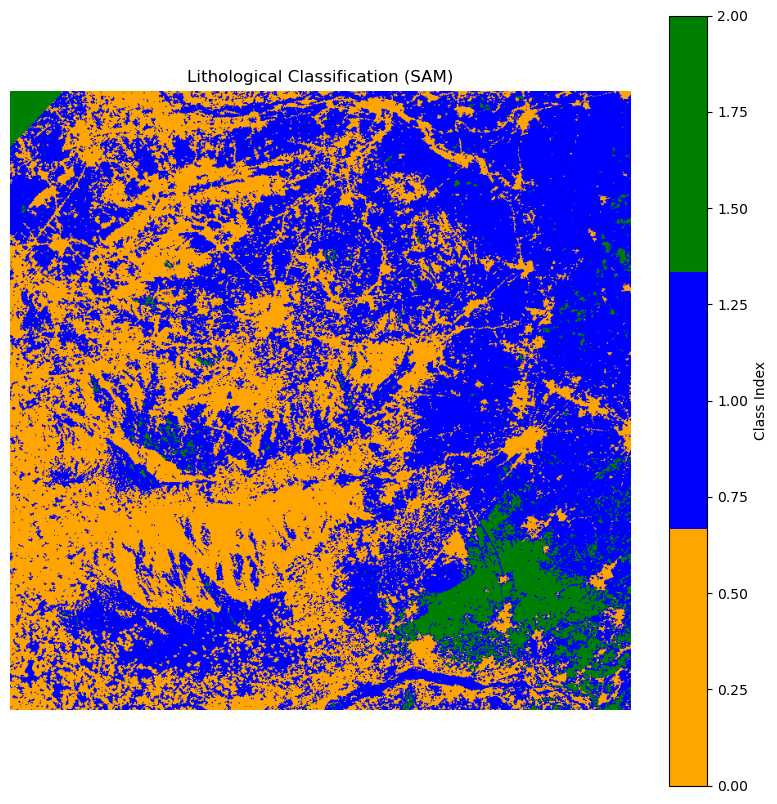

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(sam_map, cmap=cmap)
plt.title("Lithological Classification (SAM)")
plt.axis('off')
plt.colorbar(label='Class Index')
plt.show()

In [47]:
angle_r = spectral_angle(flat_img_norm, mean_rhyolite_norm)
angle_g = spectral_angle(flat_img_norm, mean_granite_norm)
angle_s = spectral_angle(flat_img_norm, mean_salt_norm)

In [48]:
threshold = 0.10  # radians ≈ 5.7 degrees

In [49]:
angles = np.stack([angle_r, angle_g, angle_s], axis=0)
min_angles = np.min(angles, axis=0)
class_indices = np.argmin(angles, axis=0)
rule_labels = np.where(min_angles < threshold, class_indices, -1)  # -1 = unclassified
rule_map = rule_labels.reshape(rows, cols)

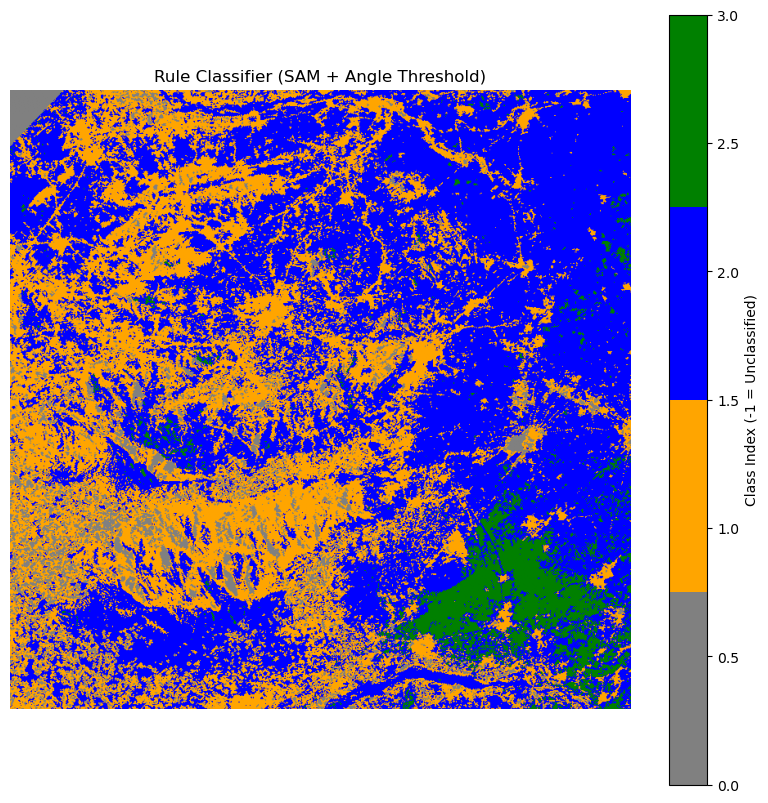

In [50]:
cmap = mcolors.ListedColormap(['orange', 'blue', 'green'])
cmap_with_unclassified = mcolors.ListedColormap(['gray', 'orange', 'blue', 'green'])  # -1, 0, 1, 2
plt.figure(figsize=(10, 10))
plt.imshow(rule_map + 1, cmap=cmap_with_unclassified)  # shift -1→0, 0→1, ...
plt.title("Rule Classifier (SAM + Angle Threshold)")
plt.axis('off')
plt.colorbar(label='Class Index (-1 = Unclassified)')
plt.show()

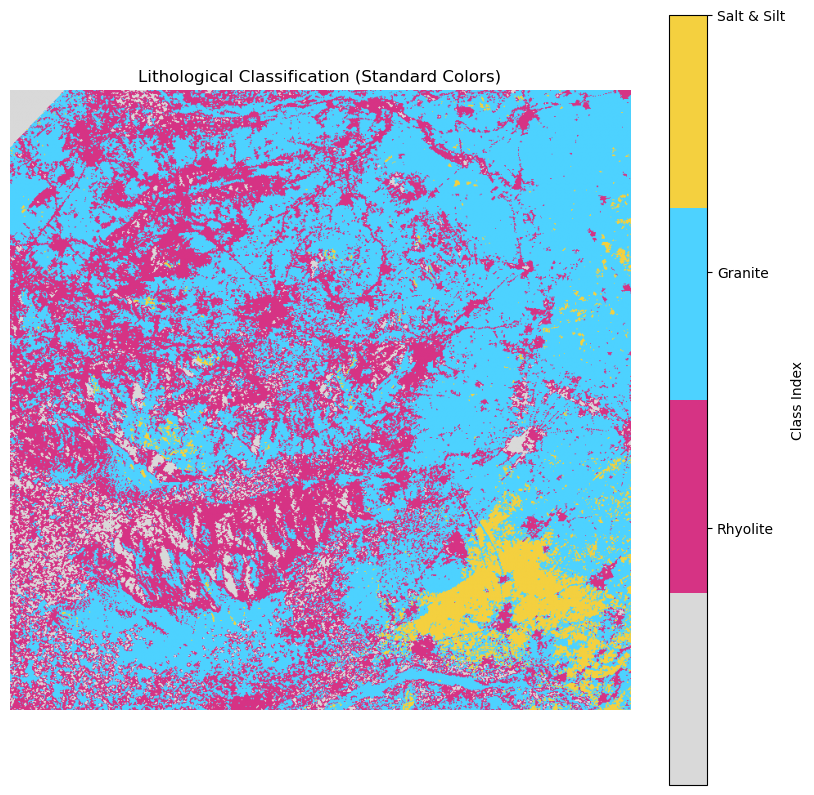

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
colors = ['#d9d9d9', '#d63384', '#4dd2ff', '#f4d03f']  # gray, red-violet, blue, tan
cmap = mcolors.ListedColormap(colors)
plot_map = rule_map + 1  # or sam_map + 1, or ann_classified + 1
plt.figure(figsize=(10, 10))
plt.imshow(plot_map, cmap=cmap)
plt.title("Lithological Classification (Standard Colors)")
plt.axis('off')
plt.colorbar(label='Class Index', ticks=[1, 2, 3], 
             format=plt.FuncFormatter(lambda val, _: ['Rhyolite', 'Granite', 'Salt & Silt'][int(val)-1]))
plt.show()

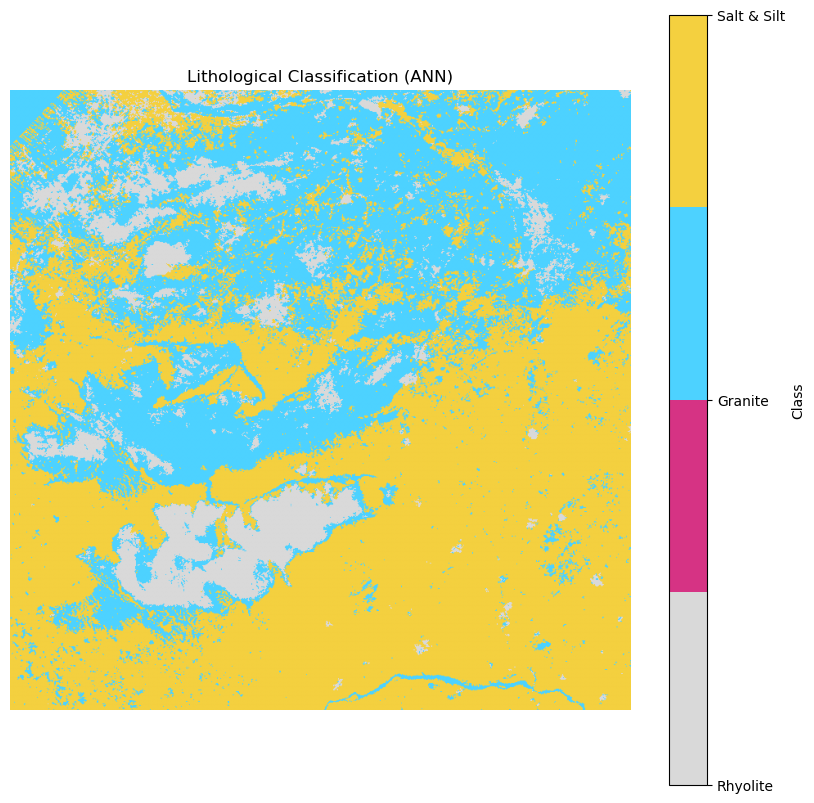

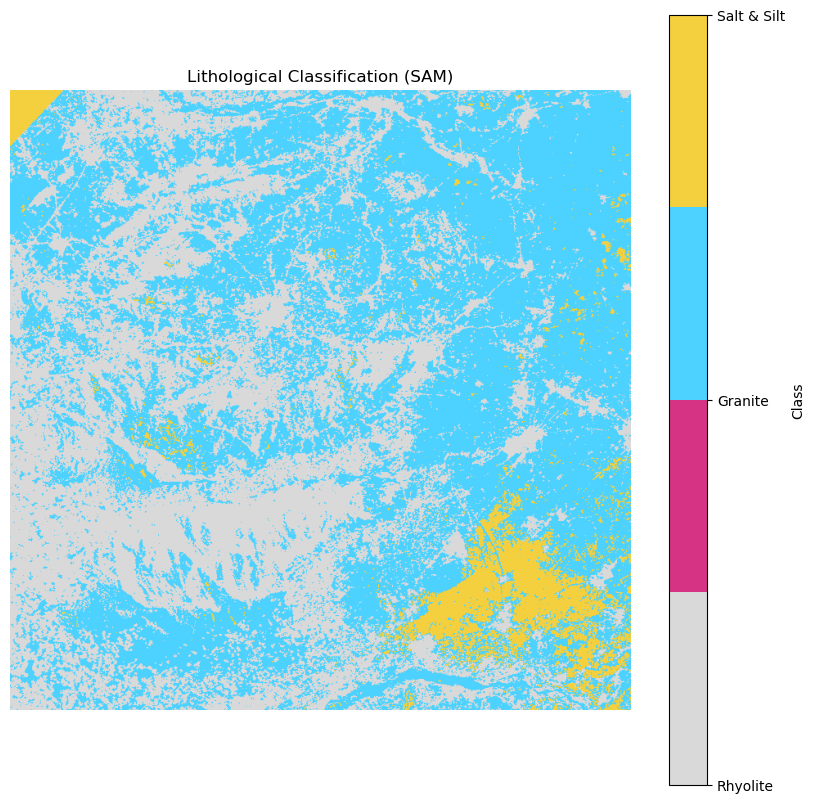

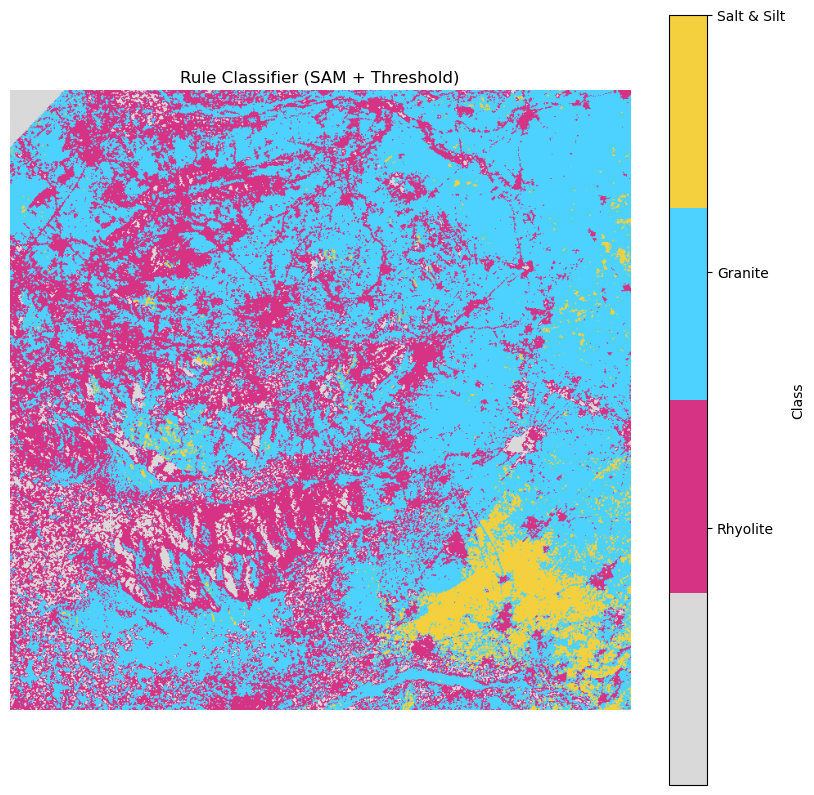

NameError: name 'rf_classified' is not defined

In [54]:
plot_litho_map(ann_classified, "Lithological Classification (ANN)")
plot_litho_map(sam_map, "Lithological Classification (SAM)")
plot_litho_map(rule_map, "Rule Classifier (SAM + Threshold)")
plot_litho_map(rf_classified, "Lithological Classification (Random Forest)")

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = ['#d9d9d9', '#d63384', '#4dd2ff', '#f4d03f']  # gray, red-violet, blue, tan
litho_cmap = mcolors.ListedColormap(colors)
class_names = ['Rhyolite', 'Granite', 'Salt & Silt']

In [53]:
def plot_litho_map(class_map, title="Classification Map"):
    shifted_map = class_map + 1  # shift -1 → 0 for colormap
    plt.figure(figsize=(10, 10))
    im = plt.imshow(shifted_map, cmap=litho_cmap)
    plt.title(title)
    plt.axis('off')
    cbar = plt.colorbar(im, ticks=[1, 2, 3])
    cbar.ax.set_yticklabels(class_names)
    cbar.set_label("Class")
    plt.show()

In [55]:
def segment_spectrum(spectrum, num_segments=5):
    seg_length = spectrum.shape[1] // num_segments
    segments = []
    for i in range(num_segments):
        seg = spectrum[:, i*seg_length:(i+1)*seg_length]
        seg_mean = np.mean(seg, axis=1)
        segments.append(seg_mean)
    return np.stack(segments, axis=1)  # shape: (pixels, segments)

In [56]:
roi_r = segment_spectrum(rhyolite_clean)  # shape: (2618, 5)
roi_g = segment_spectrum(granite_clean)   # shape: (2974, 5)
roi_s = segment_spectrum(salt_silt_clean) # shape: (2422, 5)
X_train = np.vstack([roi_r, roi_g, roi_s])
y_train = np.array([0]*len(roi_r) + [1]*len(roi_g) + [2]*len(roi_s))

In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=500, random_state=42)
clf.fit(X_train_scaled, y_train)

C:\Users\mehul\anaconda3\envs\exhype\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(16,), max_iter=500, random_state=42)

In [58]:
flat_img_segments = segment_spectrum(flat_img_norm)
flat_img_segments_scaled = scaler.transform(flat_img_segments)
pred_ann = clf.predict(flat_img_segments_scaled)
ann_img = pred_ann.reshape((rows, cols))

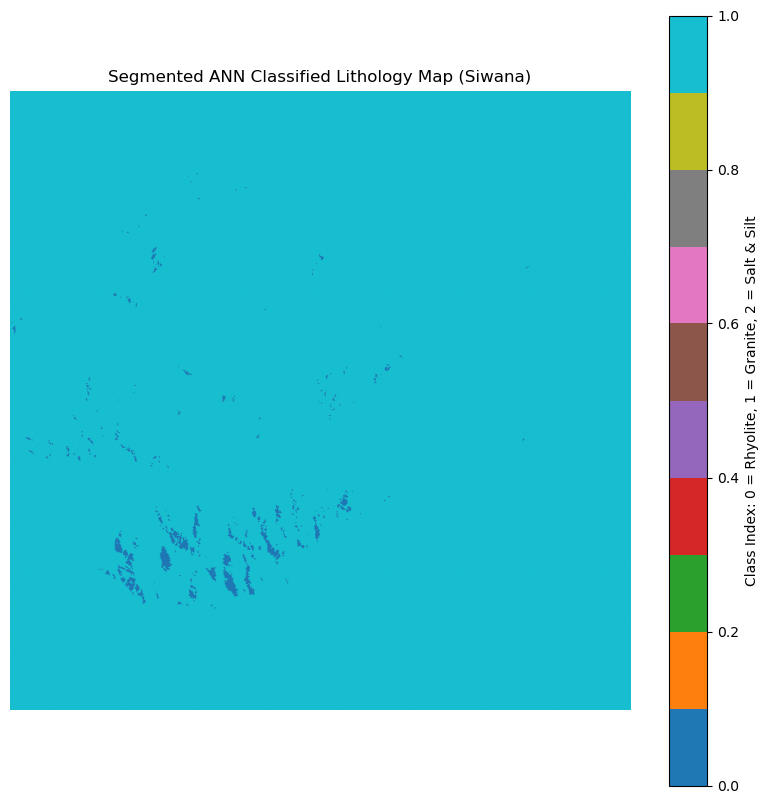

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(ann_img, cmap='tab10')
plt.title("Segmented ANN Classified Lithology Map (Siwana)")
plt.axis('off')
plt.colorbar(label="Class Index: 0 = Rhyolite, 1 = Granite, 2 = Salt & Silt")
plt.show()

In [1]:
import numpy as np
def load_roi_spectra(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    data_lines = [l for l in lines if not l.startswith(';') and len(l.strip()) > 0]
    spectra = []
    for line in data_lines:
        parts = line.strip().split()
        bands = [float(x) for x in parts[5:]] 
        spectra.append(bands)
    return np.array(spectra)
rhyolite = load_roi_spectra("RHYOLITE.txt")
granite = load_roi_spectra("granite.txt")
salt = load_roi_spectra("SALT.txt")
print("Rhyolite:", rhyolite.shape)
print("Granite:", granite.shape)
print("Salt/Silt:", salt.shape)

Rhyolite: (1338, 244)
Granite: (2307, 244)
Salt/Silt: (1744, 244)


In [61]:
bad_bands = list(range(0, 6)) + list(range(125, 136)) + list(range(145, 156)) + list(range(220, 244))
good_bands = [i for i in range(244) if i not in bad_bands]
rhyolite_clean = rhyolite[:, good_bands]
granite_clean = granite[:, good_bands]
salt_clean = salt[:, good_bands]

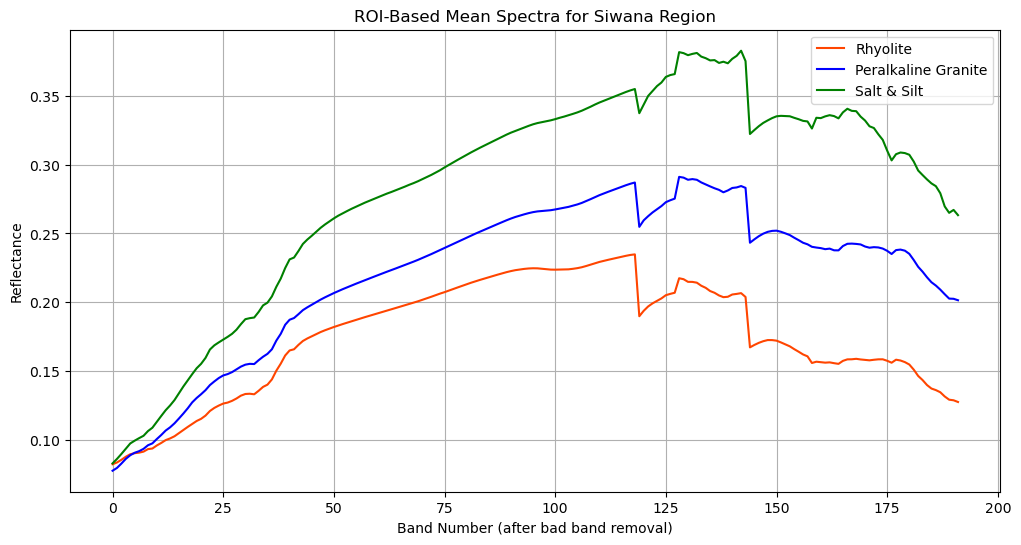

In [62]:
import matplotlib.pyplot as plt
mean_rhyolite = np.mean(rhyolite_clean, axis=0)
mean_granite = np.mean(granite_clean, axis=0)
mean_salt = np.mean(salt_clean, axis=0)
plt.figure(figsize=(12,6))
plt.plot(mean_rhyolite, label="Rhyolite", color='orangered')
plt.plot(mean_granite, label="Peralkaline Granite", color='blue')
plt.plot(mean_salt, label="Salt & Silt", color='green')
plt.title("ROI-Based Mean Spectra for Siwana Region")
plt.xlabel("Band Number (after bad band removal)")
plt.ylabel("Reflectance")
plt.legend()
plt.grid()
plt.show()